### Import required libraries

In [2]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, recall_score, precision_score

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import alexnet

/home/sscekic/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/sscekic/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load the dataset

In [4]:
datasetPath = "dataset/images/Images/"
all_breeds = os.listdir(datasetPath)
print(f"Number of different breeds: {len(all_breeds)}")

Number of different breeds: 120


Next we get the photos and labels (labels will be the index of each folder)

In [41]:
def load_images_and_labels(breeds, datasetPath):
    images=[]
    labels=[]
    label_dict = {}
    for index_zero, category in enumerate(breeds):
        index = index_zero + 1
        label_dict[index] = category.split("-")[1]
        for image_name in os.listdir(datasetPath+"/"+category):
            labels.append(index)
    return labels, label_dict
labels_list, label_dict = load_images_and_labels(all_breeds, datasetPath)
print(label_dict)

{1: 'Chihuahua', 2: 'Japanese_spaniel', 3: 'Maltese_dog', 4: 'Pekinese', 5: 'Shih', 6: 'Blenheim_spaniel', 7: 'papillon', 8: 'toy_terrier', 9: 'Rhodesian_ridgeback', 10: 'Afghan_hound', 11: 'basset', 12: 'beagle', 13: 'bloodhound', 14: 'bluetick', 15: 'black', 16: 'Walker_hound', 17: 'English_foxhound', 18: 'redbone', 19: 'borzoi', 20: 'Irish_wolfhound', 21: 'Italian_greyhound', 22: 'whippet', 23: 'Ibizan_hound', 24: 'Norwegian_elkhound', 25: 'otterhound', 26: 'Saluki', 27: 'Scottish_deerhound', 28: 'Weimaraner', 29: 'Staffordshire_bullterrier', 30: 'American_Staffordshire_terrier', 31: 'Bedlington_terrier', 32: 'Border_terrier', 33: 'Kerry_blue_terrier', 34: 'Irish_terrier', 35: 'Norfolk_terrier', 36: 'Norwich_terrier', 37: 'Yorkshire_terrier', 38: 'wire', 39: 'Lakeland_terrier', 40: 'Sealyham_terrier', 41: 'Airedale', 42: 'cairn', 43: 'Australian_terrier', 44: 'Dandie_Dinmont', 45: 'Boston_bull', 46: 'miniature_schnauzer', 47: 'giant_schnauzer', 48: 'standard_schnauzer', 49: 'Scotch_

### Data analysis 

In [43]:
labels = np.array(labels_list)

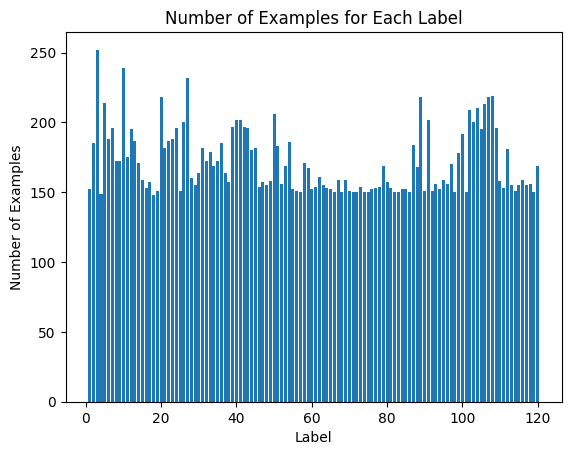

In [44]:
label_counts = np.bincount(labels)

# Plot the bar graph
plt.bar(range(1, len(label_counts)), label_counts[1:])
plt.xlabel('Label')
plt.ylabel('Number of Examples')
plt.title('Number of Examples for Each Label')
plt.show()

We can see this dataset is pretty uniform in terms of the number of the examples per class

### Transofrming and splitting the dataset

In [38]:
def GetDataLoaders(path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    dataset = ImageFolder(root=path, transform=transform)

    classes = torch.unique(torch.tensor(dataset.targets))
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size 

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

    return train_loader, test_loader, classes


train_loader, test_loader, classes = GetDataLoaders("dataset/images/Images")

Next we create the AlexNet model 

In [39]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.alexnet = alexnet(pretrained=True)
        self.alexnet.classifier[6] = nn.Linear(4096, num_classes)

    def forward(self, x):
        return self.alexnet(x)

model = AlexNet(len(classes))

/home/sscekic/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sscekic/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Next we train the model
- We experiment with different learning rates to find out the best one (0.001, 0.01, 0.1, 0.5) => The best one is **0.001**

In [42]:
lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

num_epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

loss_list = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()

Next we evaluate the model

In [49]:
model.eval()

y_true = torch.tensor([], dtype=torch.int32)
y_pred = torch.tensor([], dtype=torch.int32)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        y_true = torch.cat((y_true, labels), 0)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        y_pred = torch.cat((y_pred, predicted), 0)


In [53]:
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="macro")
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")

print(f'Accuracy on the test set: {accuracy:.4f}%')
print(f'F1 score = {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall = {recall:.4f}')

Accuracy on the test set: 0.5884%
F1 score = 0.5710
Precision: 0.5966%
Recall = 0.5798


/home/sscekic/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
